In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# Load and process the data (same as before)
def process_data(data):
    F = data[:, :9].reshape(-1, 3, 3)  # Deformation Gradient Tensor
    P = data[:, 9:18].reshape(-1, 3, 3)  # First Piola-Kirchhoff Stress Tensor
    SE = data[:, 18]  # Strain Energy Density
    return F, P, SE

# Generate random rotation matrices
def generate_rotation_matrices(num_matrices):
    rotations = []
    for _ in range(num_matrices):
        q = np.random.randn(4)  # Random quaternion
        q /= np.linalg.norm(q)  # Normalize quaternion
        r = np.array([[1 - 2 * (q[2]**2 + q[3]**2), 2 * (q[1]*q[2] - q[3]*q[0]), 2 * (q[1]*q[3] + q[2]*q[0])],
                      [2 * (q[1]*q[2] + q[3]*q[0]), 1 - 2 * (q[1]**2 + q[3]**2), 2 * (q[2]*q[3] - q[1]*q[0])],
                      [2 * (q[1]*q[3] - q[2]*q[0]), 2 * (q[2]*q[3] + q[1]*q[0]), 1 - 2 * (q[1]**2 + q[2]**2)]])
        rotations.append(r)
    return np.array(rotations)

# Augment the dataset
def augment_data(F, P, W, num_rotations=16):
    rotation_matrices = generate_rotation_matrices(num_rotations)
    F_augmented, P_augmented, W_augmented = [], [], []
    for Q in rotation_matrices:
        for Fi, Pi, Wi in zip(F, P, W):
            F_aug = Q @ Fi @ Q.T
            P_aug = Q @ Pi @ Q.T
            F_augmented.append(F_aug)
            P_augmented.append(P_aug)
            W_augmented.append(Wi)
    return np.array(F_augmented), np.array(P_augmented), np.array(W_augmented), rotation_matrices

# Load your data

data_shear = np.loadtxt('../../BCC/BCC_shear.txt')
data_uniaxial = np.loadtxt('../../BCC/BCC_uniaxial.txt')
data_biaxial = np.loadtxt('../../BCC/BCC_biaxial.txt')
data_planar = np.loadtxt('../../BCC/BCC_planar.txt')
data_uniaxial = np.loadtxt('../../BCC/BCC_uniaxial.txt')
data_volumetric = np.loadtxt('../../BCC/BCC_volumetric.txt')
data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

F_shear, P_shear, W_shear = process_data(data_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_planar, P_planar, W_planar = process_data(data_planar)
F_volumetric, P_volumetric, W_volumetric = process_data(data_volumetric)
F_test1, P_test1, W_test1 = process_data(data_test1)
F_test2, P_test2, W_test2 = process_data(data_test2)
F_test3, P_test3, W_test3 = process_data(data_test3)

#F_all = np.concatenate([F_shear, F_uniaxial, F_biaxial, F_planar, F_volumetric], axis=0)
#P_all = np.concatenate([P_shear, P_uniaxial, P_biaxial, P_planar, P_volumetric], axis=0)
#W_all = np.concatenate([W_shear, W_uniaxial, W_biaxial, W_planar, W_volumetric], axis=0)
F_all = np.concatenate([F_shear], axis=0)
P_all = np.concatenate([P_shear], axis=0)
W_all = np.concatenate([W_shear], axis=0)



In [7]:
print(F_all.shape, P_all.shape, W_all.shape)

(101, 3, 3) (101, 3, 3) (101,)


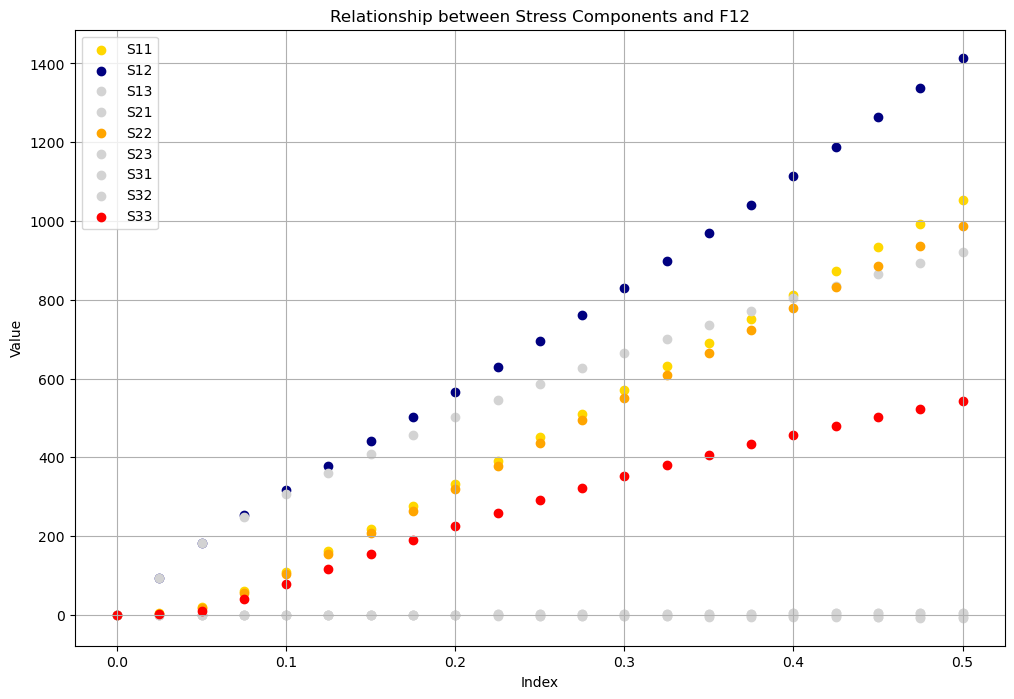

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract true data
S11_true = P_shear[:, 0, 0]
S12_true = P_shear[:, 0, 1]
S13_true = P_shear[:, 0, 2]
S21_true = P_shear[:, 1, 0]
S22_true = P_shear[:, 1, 1]
S23_true = P_shear[:, 1, 2]
S31_true = P_shear[:, 2, 0]
S32_true = P_shear[:, 2, 1]
S33_true = P_shear[:, 2, 2]
F12_true = F_shear[:, 0, 1]

# Generate x-axis values based on the length of the true data

x = F12_true[::5]
series = {
    "S11": (S11_true[::5], 'gold'),
    "S12": (S12_true[::5], 'navy'),
    "S13": (S13_true[::5], 'lightgray'),
    "S21": (S21_true[::5], 'lightgray'),
    "S22": (S22_true[::5], 'orange'),
    "S23": (S23_true[::5], 'lightgray'),
    "S31": (S31_true[::5], 'lightgray'),
    "S32": (S32_true[::5], 'lightgray'),
    "S33": (S33_true[::5], 'red'),

}


# Create the plot
plt.figure(figsize=(12, 8))

# Plot each series
for label, (data, color) in series.items():
    plt.scatter(x, data, label=label, color=color)

# Customize the plot
plt.title('Relationship between Stress Components and F12')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [9]:
# Augment the data
F_16, P_16, W_16, _ = augment_data(F_all, P_all, W_all, num_rotations=16)

# Prepare input data for training
Cof_F_16 = np.linalg.det(F_16)[:, None, None] * np.linalg.inv(F_16.transpose(0, 2, 1))
det_F_16= np.linalg.det(F_16)
F_16_inputs = np.concatenate([F_16.reshape(-1, 9), Cof_F_16.reshape(-1, 9), det_F_16[:, None]], axis=1)

# Scale data
def scale_data(P_train, W_train):
    max_abs_P = np.max(np.abs(P_train))  # Calculate scaling factor
    a = 1.0 / max_abs_P
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train
    return P_train_scaled, W_train_scaled, a

P_16_scaled, W_16_scaled, a = scale_data(P_16.reshape(-1, 9), W_16)

In [10]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(16, activation='softplus')
        self.dense2 = layers.Dense(16, activation='softplus')
        self.out_layer = layers.Dense(1, activation='linear')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out_layer(x)

    def train_step(self, data):
        X_batch, y_batch = data
        W_batch, P_batch = y_batch  # Separate targets

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape_F:
                tape_F.watch(X_batch)
                W_pred = self(X_batch, training=True)

            dW_dF = tape_F.gradient(W_pred, X_batch)[:, :9]
            loss_W = tf.reduce_mean((W_pred - W_batch) ** 2)
            loss_P = tf.reduce_mean((dW_dF - P_batch) ** 2)
            loss = loss_W + loss_P

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"loss": loss, "loss_W": loss_W, "loss_P": loss_P}


Epoch 1/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.1717 - loss_W: 0.1251 - loss_P: 0.0466
Epoch 2/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0473 - loss_W: 0.0033 - loss_P: 0.0440
Epoch 3/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0457 - loss_W: 0.0029 - loss_P: 0.0428
Epoch 4/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0447 - loss_W: 0.0028 - loss_P: 0.0419
Epoch 5/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0432 - loss_W: 0.0027 - loss_P: 0.0404
Epoch 6/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0418 - loss_W: 0.0027 - loss_P: 0.0391
Epoch 7/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0413 - loss_W: 0.0027 - loss_P: 0.0387
Epoch 8/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0398 - loss_W: 0.0026 - loss_P: 0.0372
Epoch 9/1000
51/51 [==============================] - 0s 1ms/step - loss: 0.0394

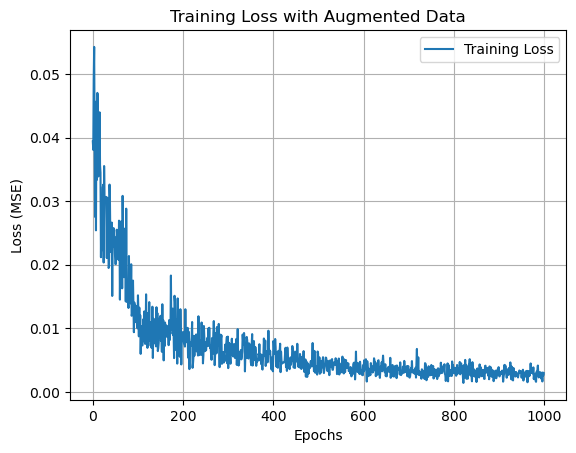

In [12]:
# Train the model
model = MyModel()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001))
history = model.fit(F_16_inputs, (W_16_scaled, P_16_scaled),batch_size=32, epochs=1000)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training Loss with Augmented Data")
plt.grid(True)
plt.show()

In [13]:
F_1024, P_1024, W_1024, rotation_matrices = augment_data(F_shear, P_shear, W_shear, num_rotations=32)
# 生成 1024 个观察者的增强数据

Cof_F_1024 = np.linalg.det(F_1024)[:, None, None] * np.linalg.inv(F_1024.transpose(0, 2, 1))
det_F_1024 = np.linalg.det(F_1024)
F_1024_input = np.concatenate([F_1024.reshape(-1, 9), Cof_F_1024.reshape(-1, 9), det_F_1024[:, None]], axis=1)

# 模型预测
F_1024_input = tf.convert_to_tensor(F_1024_input, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(F_1024_input)
    W_1024_tf = model(F_1024_input, training=False)
P_1024_tf = tape.gradient(W_1024_tf, F_1024_input)[:, :9]
#P_1024_pred = P_1024_tf.numpy().reshape(1024, -1, 3, 3) / a  # 解缩放
P_1024_pred = P_1024_tf.numpy().reshape(-1, 3, 3) / a



In [14]:
print(P_1024_pred.shape)

(3232, 3, 3)


In [19]:
import numpy as np

# 转换为 NumPy 数组
P_1024_results=[]
rotation_matrices = np.array(rotation_matrices)  # (N, 3, 3)

P_1024_results = np.array(P_1024_results)

expanded_rotation_matrices = np.tile(rotation_matrices, (101, 1, 1))  # 复制 101 次，变成 (3232, 3, 3)

# 2. 计算每个矩阵的转置
transposed_rotation_matrices = np.transpose(expanded_rotation_matrices, axes=(0, 2, 1))  # 转置形状为 (3232, 3, 3)

# 3. 矩阵乘法：对每一项执行转置后的 rotation_matrices 和 P_1024_pred 的乘法
result = np.einsum('ijk,ikl->ijl', transposed_rotation_matrices, P_1024_pred)  # 结果形状为 (3232, 3, 3)

# 输出结果
print(result.shape)  # 确认结果形状
P_1024_pred = result.reshape(32, 101, 3, 3)  # 重塑为 (32, 101, 3, 3)

(3232, 3, 3)


In [16]:
print(rotation_matrices.shape)
print(P_1024_pred.shape)


(32, 3, 3)
(3232, 3, 3)


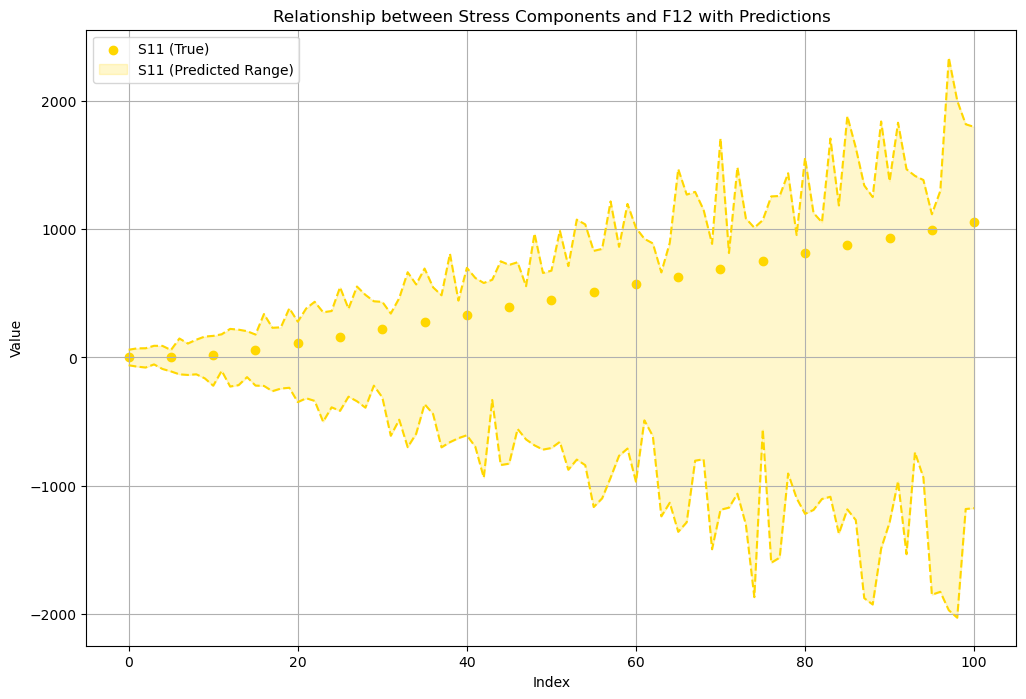

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Extract true data
S11_true = P_shear[:, 0, 0]
S12_true = P_shear[:, 0, 1]
S13_true = P_shear[:, 0, 2]
S21_true = P_shear[:, 1, 0]
S22_true = P_shear[:, 1, 1]
S23_true = P_shear[:, 1, 2]
S31_true = P_shear[:, 2, 0]
S32_true = P_shear[:, 2, 1]
S33_true = P_shear[:, 2, 2]
F12_true = F_shear[:, 0, 1]

# Predicted data (Sij_pred)
S11_pred = P_1024_pred[:, :, 0, 0]
S12_pred = P_1024_pred[:, :, 0, 1]
S13_pred = P_1024_pred[:, :, 0, 2]
S21_pred = P_1024_pred[:, :, 1, 0]
S22_pred = P_1024_pred[:, :, 1, 1]
S23_pred = P_1024_pred[:, :, 1, 2]
S31_pred = P_1024_pred[:, :, 2, 0]
S32_pred = P_1024_pred[:, :, 2, 1]
S33_pred = P_1024_pred[:, :, 2, 2]

# Generate x-axis values based on the length of the true data, reduced to 1/5 for true data only
x_true = np.arange(len(S11_true))[::5]
x_pred = np.arange(len(S11_true))  # Full range for predicted data

# Function to compute range of predicted data
def compute_range(pred):
    lower = np.min(pred, axis=0)
    upper = np.max(pred, axis=0)
    return lower, upper

# True data series
series_true = {
    "S11": (S11_true[::5], 'gold'),
 #   "S12": (S12_true[::5], 'navy'),
 #   "S13": (S13_true[::5], 'lightgray'),
 #   "S21": (S21_true[::5], 'lightgray'),
 #   "S22": (S22_true[::5], 'orange'),
 #   "S23": (S23_true[::5], 'lightgray'),
 #   "S31": (S31_true[::5], 'lightgray'),
 #   "S32": (S32_true[::5], 'lightgray'),
 #   "S33": (S33_true[::5], 'red'),
 #   "F12": (F12_true[::5], 'pink')
}
S11_lower, S11_upper = compute_range(S11_pred)
S12_lower, S12_upper = compute_range(S12_pred)
S13_lower, S13_upper = compute_range(S13_pred)
S21_lower, S21_upper = compute_range(S21_pred)
S22_lower, S22_upper = compute_range(S22_pred)
S23_lower, S23_upper = compute_range(S23_pred)
S31_lower, S31_upper = compute_range(S31_pred)
S32_lower, S32_upper = compute_range(S32_pred)
S33_lower, S33_upper = compute_range(S33_pred)

# Predicted data series (with range)
series_pred = {
    "S11": (S11_lower, S11_upper),
 #   "S12": (S12_lower, S12_upper),
 #   "S13": (S13_lower, S13_upper),
 #   "S21": (S21_lower, S21_upper),
 #   "S22": (S22_lower, S22_upper),
 #   "S23": (S23_lower, S23_upper),
 #   "S31": (S31_lower, S31_upper),
 #   "S32": (S32_lower, S32_upper),
 #   "S33": (S33_lower, S33_upper)
}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot true data
for label, (data, color) in series_true.items():
    plt.scatter(x_true, data, label=f'{label} (True)', color=color)

# Plot predicted data with range
for label, (lower, upper) in series_pred.items():
    plt.plot(x_pred, lower, linestyle='--', color=series_true[label][1])
    plt.plot(x_pred, upper, linestyle='--', color=series_true[label][1])
    plt.fill_between(x_pred, lower, upper, alpha=0.2, color=series_true[label][1], label=f'{label} (Predicted Range)')

# Customize the plot
plt.title('Relationship between Stress Components and F12 with Predictions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [ ]:
print(S11_pred.shape)
print(S11_true.shape)
lower, upper = compute_range(S11_pred)
print(lower.shape)


(1024, 101)
(101,)
(101,)
